In [1]:
import glob
import matplotlib.pyplot as plt
import os
import re
import imageio.v2 as imageio
import numpy as np
import pandas as pd
import boto3
import cv2

In [2]:
# Inputs
transaction_ID = '200013'


In [3]:
# Function to extract the numeric value from filenames
def extract_row_col(filepath):
    match = re.findall(r'(\d+)', os.path.basename(filepath))  # Find all numbers in filename
    if len(match) >= 3:
        return (int(match[1]), int(match[2]))  # Use second and third numbers (row, col)
    return (9999, 9999)  # Default large number to push problematic files to the end

# Get all the input images and sort them numerically
# folder_data_input = sorted(
#     glob.glob(os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection","acquisition", transaction_ID, "*tif")),
#     key= extract_row_col
# )
folder_data_input = sorted(
    glob.glob(os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection","image_enhancement", transaction_ID, "*tif")),
    key= extract_row_col
)


folder_data_preds = sorted(
    glob.glob(os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection","prediction", transaction_ID, "*tif")),
    key= extract_row_col
)


In [4]:
input_image_paths = folder_data_input[:]
preds_image_paths = folder_data_preds[:]

print(input_image_paths)
print(120*"-")
print(f'Number of files in the acquisition ID "{transaction_ID}": {len(input_image_paths)}')


['/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_000_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_000_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_000_002.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_000_003.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_000_004.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_001_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_001_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_001_002.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_001_003.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/image_enhancement/200013/200013_001_004.tif', '/home/sagemaker-us

In [5]:
print(preds_image_paths)
print(120*"-")
print(f'Number of files in the acquisition ID "{transaction_ID}": {len(preds_image_paths)}')

['/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_000_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_000_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_000_002.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_000_003.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_000_004.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_001_000.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_001_001.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_001_002.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_001_003.tif', '/home/sagemaker-user/satellite-ml-solarp-detection/prediction/200013/pred_200013_001_004.tif', '/home/sagemaker-user/satellite-ml-sola

In [6]:
# Determine the the grid size
nb_of_rows = int(input_image_paths[-1][-11:-8]) + 1
nb_of_cols = int(input_image_paths[-1][-7:-4]) + 1

print(f'Grid shape: {nb_of_rows} rows by {nb_of_cols} cols.')



Grid shape: 4 rows by 5 cols.


In [22]:
# Generate Report image using a Mosaic Display
def create_mosaic(image_paths, title, nb_of_rows, nb_of_cols):
    
    images = []
    
    for path in image_paths:
        img = imageio.imread(path).astype(np.float32)

        # If image has 4 bands, extract RGB only (bands 1, 2, 3)
        if len(img.shape) == 3 and img.shape[-1] == 4:
            img = img[:, :, :3]  # Keep only RGB channels

        images.append(img)

    # Convert images to a single numpy array for global normalization
    images = np.array(images)
    
    # Normalize based on min/max scaling per band
    if title.lower() == "input":
        min_val, max_val = images.min(), images.max()
        images = ((images - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    elif title.lower() == "prediction":
        images = (images > 0).astype(np.uint8) * 255 # scale binary mask

    # Get image dimensions
    img_height, img_width, _ = images[0].shape if len(images[0].shape) == 3 else (images[0].shape[0], images[0].shape[1], 1)
    
    # Create the mosaic
    mosaic = np.vstack([
        np.hstack(images[i * nb_of_cols:(i + 1) * nb_of_cols])
        for i in range(nb_of_rows)
    ])
    
    # Ensure directory exists
    image_dir = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports", transaction_ID)
    os.makedirs(image_dir, exist_ok=True)

    # Save as PNG (no TIFF)
    image_path = os.path.join(image_dir, f"{title}.png")

    # Normalize input images before saving
    imageio.imwrite(image_path, mosaic)
            
    print(f"Saved mosaic: {image_path}")
    return image_path

In [23]:
# Generate Report (Mosaic Display)
def plot_mosaic(mosaic_path, image_type):
    plt.figure(figsize=(12, 12))

    img = imageio.imread(mosaic_path)
    
    if image_type.lower() == 'input':
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = img / 255.0  # Convert to 0-1 range for float images in imshow()
        
    elif image_type.lower() == 'prediction':
        img = img.astype(np.uint8)  # Ensure binary mask stays 0-255
    else:
        raise ValueError("Invalid type. Use 'input'or 'prediction'")
    
    plt.imshow(img, cmap="gray" if image_type == 'prediction' else None)
    plt.axis("off")
    plt.show()

    

In [24]:
# # Generate Report (Mosaic Display)
# def plot_mosaic(image_paths, title, nb_of_rows, nb_of_cols):
#     fig, axes = plt.subplots(nb_of_rows, nb_of_cols, figsize=(12, 12))
#     axes = axes.ravel()
    
#     for idx, img_path in enumerate(image_paths):
#         img = imageio.imread(img_path).astype(np.float32)
        
#         # acquisition 4 band images 
#         if len(img.shape) == 3 and img.shape[-1] == 4:  # If 4 bands, use rgb only
#             img = img[:, :, :3]  # Extract only the first 3 channels (RGB)
#             img = (img - np.min(img)) / (np.max(img) - np.min(img)) if np.max(img) > 1 else img
            
#         # predictions 1 band images
#         elif len(img.shape) == 2:  # Binary mask images
#             img = img.astype(np.uint8)
            
            
#         axes[idx].imshow(img, cmap="gray" if len(img.shape) == 2 else None)
#         #axes[idx].set_title(f"{title} {idx+1}")
#         axes[idx].axis("off")

#     #plt.subplots_adjust(wspace=-0.01, hspace=-0.01)
#     plt.subplots_adjust(wspace=0, hspace=0)
#     #plt.tight_layout()

#     # Ensure the directory exists before saving
#     image_dir = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports", transaction_ID)
#     os.makedirs(image_dir, exist_ok=True)  # Create the directory if it doesn’t exist

#     # Save the file in the correct location
#     image_path = os.path.join(image_dir, f'{title}.png')
#     plt.savefig(image_path, bbox_inches='tight', dpi=300)
#     print(f"Saved mosaic: {image_path}")
#     plt.show()

#     return image_path


Saved mosaic: /home/sagemaker-user/satellite-ml-solarp-detection/reports/200013/input.png


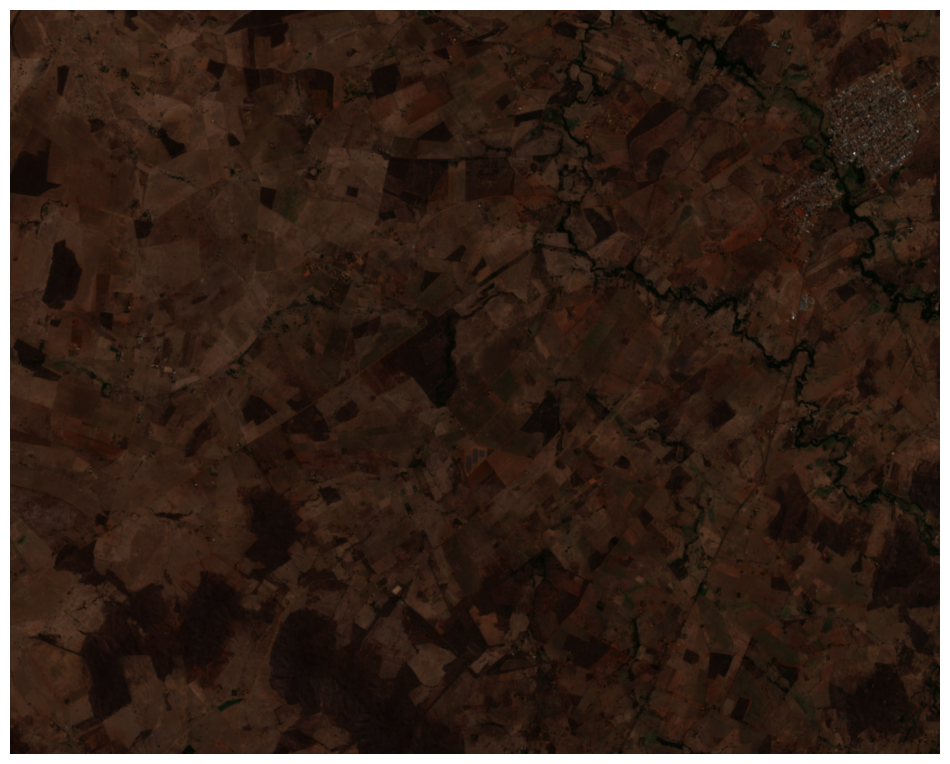

In [25]:
# Plot input and prediction mosaics
input_mosaic_path = create_mosaic(input_image_paths, "input", nb_of_rows, nb_of_cols)
plot_mosaic(input_mosaic_path, 'input')


Saved mosaic: /home/sagemaker-user/satellite-ml-solarp-detection/reports/200013/prediction.png


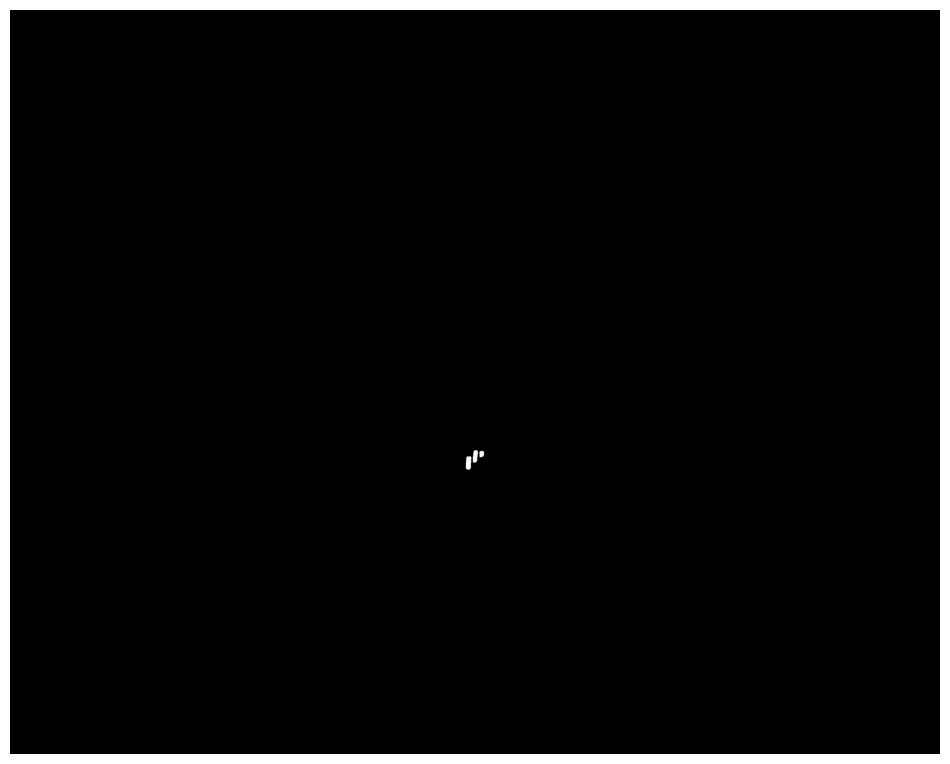

In [26]:
# Plot input and prediction mosaics
pred_mosaic_path = create_mosaic(preds_image_paths, "prediction", nb_of_rows, nb_of_cols)
plot_mosaic(pred_mosaic_path, 'prediction')


In [37]:
def overlay_prediction(input_path, prediction_path, output_path, overlay_color=(255, 0, 0), alpha=0.5):
    """
    Overlay binary prediction mask over the input image with transparency.
    
    Parameters:
        input_path (str): Path to the input mosaic image.
        prediction_path (str): Path to the binary mask mosaic.
        output_path (str): Path to save the overlay image.
        overlay_color (tuple): Color of the overlay (default: Red).
        alpha (float): Transparency level of the overlay (0=fully transparent, 1=fully opaque).
    """
    
    # Load input image
    input_img = cv2.imread(input_path, cv2.IMREAD_COLOR)
    
    # Load binary mask and convert to grayscale
    pred_mask = cv2.imread(prediction_path, cv2.IMREAD_GRAYSCALE)

    # Ensure input is in RGB format (OpenCV loads images as BGR)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

    # Create a color overlay where white pixels in the mask get a color
    overlay = np.zeros_like(input_img, dtype=np.uint8)  # Create an empty overlay (black)
    
    # Apply the overlay color only to the mask's white areas
    overlay[pred_mask > 0] = overlay_color

    # Blend overlay with input image (only where mask is present)
    blended = cv2.addWeighted(input_img, 1, overlay, alpha, 0)

    # Save the final overlayed image
    imageio.imwrite(output_path, blended)
    print(f"Saved overlay image: {output_path}")



In [40]:
# Define the path to save overlay image
overlay_path = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports", transaction_ID, "overlay.png")

# Apply overlay function with RED overlay color
overlay_prediction(input_mosaic_path, pred_mosaic_path, overlay_path, overlay_color=(0, 255, 255), alpha=0.5)


Saved overlay image: /home/sagemaker-user/satellite-ml-solarp-detection/reports/200013/overlay.png


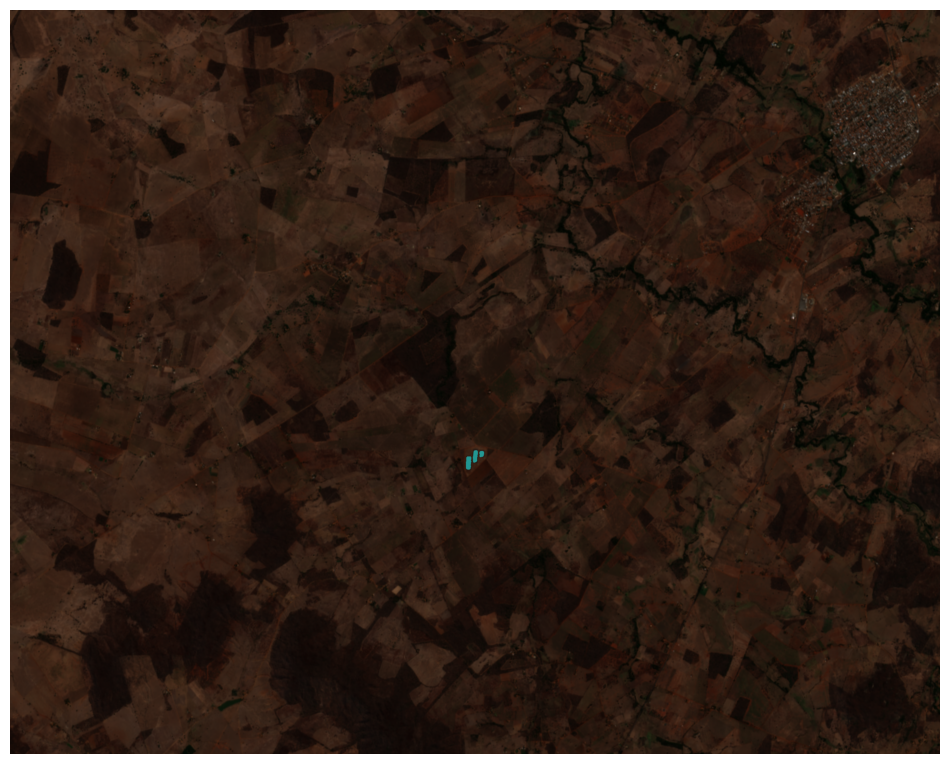

In [41]:
plot_mosaic(overlay_path, 'input')

In [44]:
# def overlay_grid(image_path, output_path, nb_of_rows, nb_of_cols, line_color=(255, 255, 255), thickness=1, line_type=cv2.LINE_AA):
#     """
#     Overlay a dotted grid on the image.
    
#     Parameters:
#         image_path (str): Path to the overlay image.
#         output_path (str): Path to save the new overlay image with the grid.
#         nb_of_rows (int): Number of rows in the grid.
#         nb_of_cols (int): Number of columns in the grid.
#         line_color (tuple): Color of the grid lines (default: White).
#         thickness (int): Line thickness.
#         line_type (int): OpenCV line type (default: Anti-aliased LINE_AA).
#     """

#     # Load the overlay image
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     height, width, _ = img.shape

#     # Calculate cell size
#     cell_width = width // nb_of_cols
#     cell_height = height // nb_of_rows

#     counter = 

#     # Draw vertical dotted lines
#     for col in range(1, nb_of_cols):
#         x = col * cell_width
#         for y in range(0, height, 10):  # Dotted effect
#             if y % 20 < 10:
#                 cv2.line(img, (x, y), (x, y + 10), line_color, thickness, line_type)

#     # Draw horizontal dotted lines
#     for row in range(1, nb_of_rows):
#         y = row * cell_height
#         for x in range(0, width, 10):  # Dotted effect
#             if x % 20 < 10:
#                 cv2.line(img, (x, y), (x + 10, y), line_color, thickness, line_type)

#     # Save the new image
#     cv2.imwrite(output_path, img)
#     print(f"Saved overlay with grid: {output_path}")


def overlay_grid(image_path, output_path, nb_of_rows, nb_of_cols, line_color=(255, 255, 255), text_color=(255, 255, 255)):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    cell_width = width // nb_of_cols
    cell_height = height // nb_of_rows
    
    counter = 1
    for row in range(nb_of_rows):
        for col in range(nb_of_cols):
            x = col * cell_width
            y = row * cell_height
            
            # Draw grid cell number in the top-left corner
            cv2.putText(img, str(counter), (x + 5, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
            counter += 1
            
            # Draw dotted vertical lines
            for i in range(0, height, 10):
                if i % 20 < 10:
                    cv2.line(img, (x, i), (x, i + 10), line_color, 1)
            
            # Draw dotted horizontal lines
            for i in range(0, width, 10):
                if i % 20 < 10:
                    cv2.line(img, (i, y), (i + 10, y), line_color, 1)
    
    cv2.imwrite(output_path, img)
    print(f"Saved overlay with grid: {output_path}")

In [45]:
# Define the path to save the grid overlay image
grid_overlay_path = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports", transaction_ID, "overlay_grid.png")

# Apply the function
overlay_grid(overlay_path, grid_overlay_path, nb_of_rows, nb_of_cols)

Saved overlay with grid: /home/sagemaker-user/satellite-ml-solarp-detection/reports/200013/overlay_grid.png


-----


In [56]:
# Compute Statistics
def compute_statistics(predicted_paths):
    stats = []
    counter = 1
    for path in predicted_paths:
        pred_img = imageio.imread(path)
        total_pixels = pred_img.size
        positive_pixels = np.sum(np.asarray(pred_img) > 0)
        coverage_percentage = (positive_pixels / total_pixels) * 100
        stats.append({
            "Cell": counter,
            "Total Pixels": total_pixels,
            "Positive Pixels": positive_pixels,
            "Coverage %": coverage_percentage
        })
        counter += 1
        
    return pd.DataFrame(stats).reset_index(drop=True)

stats_df = compute_statistics(preds_image_paths)
print(stats_df)

# Save the report as a CSV
report_path = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports",transaction_ID, "stats.csv")
os.makedirs(os.path.dirname(report_path), exist_ok=True)
stats_df.to_csv(report_path, index=False)
print(f"Report saved: {report_path}")


    Cell  Total Pixels  Positive Pixels  Coverage %
0      1        262144                0    0.000000
1      2        262144                0    0.000000
2      3        262144                0    0.000000
3      4        262144                0    0.000000
4      5        262144                0    0.000000
5      6        262144                0    0.000000
6      7        262144                0    0.000000
7      8        262144                0    0.000000
8      9        262144                0    0.000000
9     10        262144                0    0.000000
10    11        262144                0    0.000000
11    12        262144                0    0.000000
12    13        262144             1059    0.403976
13    14        262144                0    0.000000
14    15        262144                0    0.000000
15    16        262144                0    0.000000
16    17        262144                0    0.000000
17    18        262144                0    0.000000
18    19    

In [59]:
html_report_path = os.path.join(os.path.expanduser("~"), "satellite-ml-solarp-detection", "reports", transaction_ID, "report.html")
html_content = f"""
<html>
<head><title>Satellite Report {transaction_ID}</title></head>
<body>
<h2>Satellite Report for Transaction ID: {transaction_ID}</h2>
<h3>Satellite Imagery & Detection Mosaic</h3>
<img src='overlay_grid.png' width='800'>
<h3>Statistics</h3>
{stats_df.to_html(index=False)}
</body>
</html>
"""
with open(html_report_path, "w") as file:
    file.write(html_content)
print(f"HTML report saved: {html_report_path}")



HTML report saved: /home/sagemaker-user/satellite-ml-solarp-detection/reports/200013/report.html


-----

In [32]:
# AWS S3 Upload
s3_bucket = "satellite-ml-solarp-detection-reports"
s3_client = boto3.client("s3")

def upload_to_s3(local_path, bucket, s3_path):
    try:
        s3_client.upload_file(local_path, bucket, s3_path)  #, ExtraArgs={'ACL': 'bucket-owner-full-control'})
        return f"https://{bucket}.s3.amazonaws.com/{s3_path}"
    except Exception as e:
        print(f"Failed to upload {local_path} to S3: {e}")
        return None


In [33]:
# Upload report files to S3
input_img_url = upload_to_s3(input_mosaic_path, s3_bucket, f"reports/{transaction_ID}/input.png")
pred_img_url = upload_to_s3(pred_mosaic_path, s3_bucket, f"reports/{transaction_ID}/prediction.png")
html_report_url = upload_to_s3(html_report_path, s3_bucket, f"reports/{transaction_ID}/report.html")
csv_report_url = upload_to_s3(report_path, s3_bucket, f"reports/{transaction_ID}/report.csv")


In [34]:
print(f"HTML Report: {html_report_url}")
print(f"Input Mosaic: {input_img_url}")
print(f"Prediction Mosaic: {pred_img_url}")
print(f"CSV Report: {csv_report_url}")

HTML Report: https://satellite-ml-solarp-detection-reports.s3.amazonaws.com/reports/200013/report.html
Input Mosaic: https://satellite-ml-solarp-detection-reports.s3.amazonaws.com/reports/200013/input.png
Prediction Mosaic: https://satellite-ml-solarp-detection-reports.s3.amazonaws.com/reports/200013/prediction.png
CSV Report: https://satellite-ml-solarp-detection-reports.s3.amazonaws.com/reports/200013/report.csv
